<a href="https://colab.research.google.com/github/Kaverishende/Home.llc/blob/main/Home_LLC_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Study of effect of national factors on home prices in US

**Task -** Using publically available data for the national factors that impact supply and demand of homes in US, build a model to study the effect of these variables on home prices.

**Approach -** The following variables are chosen for the study-
- Unemployment Rate
- Per Capita GDP
- Median Household Income
- Construction Prices
- CPI
- Interest Rates
- Number of new houses supplied
- Working Population
- Urban Population
- Percentage of population above 65
- Housing subsidies
- Number of Households

As a proxy to the home prices, S&P CASE-SHILLER Index is used.

Most of the data is downloaded from [https://fred.stlouisfed.org/].

Data for all the variables is downloaded, preprocessed and combined to create a datset. Data for different variables had different frequencies. So, to combine the data, necessary interpolations are made.

Linear Regression is used as most of the variables have high correlation with the target variable.

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Reading CASE-SHILLER Index into a dataframe
df_CS = pd.read_csv("/content/drive/MyDrive/Home.LLC.company/Copy of Copy of S&PCase-Shiller U.S. National Home Price Index (CSUSHPISA).csv")

#Changing dtype of date column
df_CS["DATE"] = pd.to_datetime(df_CS["DATE"])

#Selecting data post JUNE 2001
mask = df_CS["DATE"] >= "2001-07-01"
df_CS = df_CS[mask]

#Resetting Index
df_CS.reset_index(inplace = True)
df_CS.drop(columns = ["index"], inplace = True)

# Creating "Year" and "Month" columns
df_CS["Year"] = pd.DatetimeIndex(df_CS["DATE"]).year
df_CS["Month"] = pd.DatetimeIndex(df_CS["DATE"]).month
print(df_CS.shape)
df_CS.tail()

(267, 4)


<ipython-input-3-908f0acf7752>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CS.drop(columns = ["index"], inplace = True)
<ipython-input-3-908f0acf7752>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CS["Year"] = pd.DatetimeIndex(df_CS["DATE"]).year
<ipython-input-3-908f0acf7752>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

,DATE,CSUSHPISA,Year,Month
262,2023-05-01,302.566,2023,5
263,2023-06-01,304.593,2023,6
264,2023-07-01,306.767,2023,7
265,2023-08-01,309.155,2023,8
266,2023-09-01,311.175,2023,9


In [4]:
# Reading Unemployment Rate Data into a dataframe
df_unemp = pd.read_csv("/content/drive/MyDrive/Home.LLC.company/Copy of Copy of Unemployment Rate (UNRATE).csv")
df_unemp.drop([252,253], inplace = True)
print(df_unemp.shape)
df_unemp.tail()

(909, 2)


,DATE,UNRATE
906,2023-07-01,3.5
907,2023-08-01,3.8
908,2023-09-01,3.8
909,2023-10-01,3.9
910,2023-11-01,3.7


In [5]:
# Reading Per Capita GDP Data into a dataframe
df_pcgdp = pd.read_csv("/content/drive/MyDrive/Home.LLC.company/Copy of Copy of Real gross domestic product per capita (A939RX0Q048SBEA).csv", names = ["DATE", "Per_Capita_GDP"], skiprows = 1)
print(df_pcgdp.shape)
df_pcgdp.tail()

(307, 2)


,DATE,Per_Capita_GDP
302,2022-07-01,65462.0
303,2022-10-01,65783.0
304,2023-01-01,66078.0
305,2023-04-01,66341.0
306,2023-07-01,67083.0


The data is quarterly. We will impute for other months using linear interpolation after we create the final dataframe combining all the data.

In [6]:
# Interest Rate Data
df_Fed_rate = pd.read_csv("/content/drive/MyDrive/Home.LLC.company/Copy of Federal Funds Effective Rate (FEDFUNDS).csv").drop([252,253])
print(df_Fed_rate.shape)
df_Fed_rate.tail()

(831, 2)


,DATE,FEDFUNDS
828,2023-07-01,5.12
829,2023-08-01,5.33
830,2023-09-01,5.33
831,2023-10-01,5.33
832,2023-11-01,5.33


In [7]:
# Reading Per Capita GDP Data into a dataframe
df_cons_price_index = pd.read_csv("/content/drive/MyDrive/Home.LLC.company/Copy of Producer Price Index by Commodity Special Indexes Construction Materials (WPUSI012011).csv", names = ["DATE", "Cons_Materials"], skiprows = 1)
df_cons_price_index.drop([252], inplace = True)
print(df_cons_price_index.shape)
df_cons_price_index.tail()

(921, 2)


,DATE,Cons_Materials
917,2023-06-01,337.336
918,2023-07-01,334.576
919,2023-08-01,333.980
920,2023-09-01,332.224
921,2023-10-01,329.690


In [8]:
# Consumer Price Index
df_CPI = pd.read_csv("/content/drive/MyDrive/Home.LLC.company/Copy of Copy of Consumer Price Index_CUUR0000SEHA.csv", names = ["DATE", "CPI"], skiprows = 1).drop([252])
print(df_CPI.shape)
df_CPI.tail()

(1306, 2)


,DATE,CPI
1302,2023-06-01,398.593
1303,2023-07-01,400.210
1304,2023-08-01,402.247
1305,2023-09-01,404.487
1306,2023-10-01,406.683


In [9]:
# Monthly new house supply
df_house = pd.read_csv("/content/drive/MyDrive/Home.LLC.company/Copy of Copy of Monthly Supply of New Houses in the United States (MSACSR).csv", names = ["DATE", "Houses"], skiprows = 1).drop([252])
print(df_house.shape)
df_house.tail()

(729, 2)


,DATE,Houses
725,2023-06-01,7.5
726,2023-07-01,7.1
727,2023-08-01,7.8
728,2023-09-01,7.2
729,2023-10-01,7.8


In [10]:
# Population above 65

df_oldpop = pd.read_csv("/content/drive/MyDrive/Home.LLC.company/Copy of Copy of Population ages 65 and above for the United States (SPPOP65UPTOZSUSA).csv", names = ["DATE", "old_percent"], skiprows = 1)
print(df_oldpop.shape)
df_oldpop.tail()

(63, 2)


,DATE,old_percent
58,2018-01-01,15.397698
59,2019-01-01,15.791801
60,2020-01-01,16.223400
61,2021-01-01,16.678895
62,2022-01-01,17.128121


In [ ]:
# # Urban Population Percent

# df_urban = pd.read_excel("urban_pop.ods", engine = "odf")
# print(df_urban.shape)
# df_urban.tail()

In [11]:
# Housing Subsidies

df_subsidy = pd.read_csv("/content/drive/MyDrive/Home.LLC.company/Copy of Copy of Government subsidies Federal Housing (L312051A027NBEA).csv", names = ["DATE", "Subsidy"], skiprows = 1)
print(df_subsidy.shape)
df_subsidy.tail()

(63, 2)


,DATE,Subsidy
58,2018-01-01,38.859
59,2019-01-01,40.185
60,2020-01-01,44.147
61,2021-01-01,45.299
62,2022-01-01,48.021


In [12]:
# Working age population

df_working = pd.read_csv("/content/drive/MyDrive/Home.LLC.company/Copy of Copy of Working Age Population Aged 15-64 All Persons for United States (LFWA64TTUSM647S).csv", names = ["DATE", "Working_Population"], skiprows = 1).drop([252])
print(df_working.shape)
df_working.tail()

(561, 2)


,DATE,Working_Population
557,2023-06-01,2.087069e+08
558,2023-07-01,2.087792e+08
559,2023-08-01,2.089066e+08
560,2023-09-01,2.091172e+08
561,2023-10-01,2.090394e+08


In [13]:
# Real Median Household Income

df_income = pd.read_csv("/content/drive/MyDrive/Home.LLC.company/Copy of Copy of Real Median Household Income in the United States (MEHOINUSA672N).csv", names = ["DATE", "Income"], skiprows = 1)
print(df_income.shape)
df_income.tail()

(39, 2)


,DATE,Income
34,2018-01-01,73030
35,2019-01-01,78250
36,2020-01-01,76660
37,2021-01-01,76330
38,2022-01-01,74580


In [14]:
# Number of households

df_households = pd.read_csv("/content/drive/MyDrive/Home.LLC.company/Copy of Copy of Total Households (TTLHH).csv", names = ["DATE", "Num_Households"], skiprows = 1)
print(df_households.shape)
df_households.tail()

(84, 2)


,DATE,Num_Households
79,2019-01-01,128579.0
80,2020-01-01,128451.0
81,2021-01-01,129224.0
82,2022-01-01,131202.0
83,2023-01-01,131434.0


In [15]:
# Merging Per Capita GDP (Quarterly data)
df_pcgdp["DATE"] = pd.to_datetime(df_pcgdp["DATE"])
df_CS = pd.merge(df_CS,df_pcgdp, how = "left")

In [16]:
# Concating dataframes having monthly data to create one dataframe
df = pd.DataFrame()
df_bymonth = [df_CS, df_working, df_house, df_CPI, df_unemp, df_cons_price_index, df_Fed_rate]
for df1 in df_bymonth:
    df1["DATE"] = pd.to_datetime(df1["DATE"])
    # df1 = df1.set_index("DATE")
    df = pd.concat([df,df1], axis = 1)
print(df.shape)
df.head()

(1307, 17)


,DATE,CSUSHPISA,Year,Month,Per_Capita_GDP,DATE,Working_Population,DATE,Houses,DATE,CPI,DATE,UNRATE,DATE,Cons_Materials,DATE,FEDFUNDS
0,2001-07-01,113.491,2001.0,7.0,49774.0,1977-01-01,1.351458e+08,1963-01-01,4.7,1914-12-01,21.000,1948-01-01,3.4,1947-01-01,22.2,1954-07-01,0.80
1,2001-08-01,114.167,2001.0,8.0,NaN,1977-02-01,1.353511e+08,1963-02-01,6.6,1915-01-01,.,1948-02-01,3.8,1947-02-01,22.5,1954-08-01,1.22
2,2001-09-01,114.812,2001.0,9.0,NaN,1977-03-01,1.355740e+08,1963-03-01,6.4,1915-02-01,.,1948-03-01,4.0,1947-03-01,22.9,1954-09-01,1.07
3,2001-10-01,115.310,2001.0,10.0,49783.0,1977-04-01,1.358389e+08,1963-04-01,5.3,1915-03-01,.,1948-04-01,3.9,1947-04-01,23.2,1954-10-01,0.85
4,2001-11-01,115.857,2001.0,11.0,NaN,1977-05-01,1.361395e+08,1963-05-01,5.1,1915-04-01,.,1948-05-01,3.5,1947-05-01,23.3,1954-11-01,0.83


In [17]:
# Merging other dataframes
others = [ df_households, df_income, df_subsidy, df_oldpop]
for df1 in others:
    if "Year" not in df1.columns:
        df1["Year"] = pd.DatetimeIndex(df1["DATE"]).year
        df1.set_index("DATE", inplace = True)
        df = pd.merge(df, df1, how = "left", on = "Year")
    else:
        df1.set_index("DATE", inplace = True)
        df = pd.merge(df, df1, how = "left", on = "Year")
df["DATE"] = df_CS["DATE"]
# df.set_index("DATE", inplace = True)
df.head()

,DATE,CSUSHPISA,Year,Month,Per_Capita_GDP,DATE,Working_Population,DATE,Houses,DATE,...,DATE,UNRATE,DATE,Cons_Materials,DATE,FEDFUNDS,Num_Households,Income,Subsidy,old_percent
0,2001-07-01,113.491,2001.0,7.0,49774.0,2001-07-01,1.351458e+08,2001-07-01,4.7,2001-07-01,...,2001-07-01,3.4,2001-07-01,22.2,2001-07-01,0.80,108209,66360.0,20.573,12.296945
1,2001-08-01,114.167,2001.0,8.0,NaN,2001-08-01,1.353511e+08,2001-08-01,6.6,2001-08-01,...,2001-08-01,3.8,2001-08-01,22.5,2001-08-01,1.22,108209,66360.0,20.573,12.296945
2,2001-09-01,114.812,2001.0,9.0,NaN,2001-09-01,1.355740e+08,2001-09-01,6.4,2001-09-01,...,2001-09-01,4.0,2001-09-01,22.9,2001-09-01,1.07,108209,66360.0,20.573,12.296945
3,2001-10-01,115.310,2001.0,10.0,49783.0,2001-10-01,1.358389e+08,2001-10-01,5.3,2001-10-01,...,2001-10-01,3.9,2001-10-01,23.2,2001-10-01,0.85,108209,66360.0,20.573,12.296945
4,2001-11-01,115.857,2001.0,11.0,NaN,2001-11-01,1.361395e+08,2001-11-01,5.1,2001-11-01,...,2001-11-01,3.5,2001-11-01,23.3,2001-11-01,0.83,108209,66360.0,20.573,12.296945


In [18]:
df.isna().sum()

DATE                  1040
CSUSHPISA             1040
Year                  1040
Month                 1040
Per_Capita_GDP        1218
DATE                  1040
Working_Population     746
DATE                  1040
Houses                 578
DATE                  1040
CPI                      1
DATE                  1040
UNRATE                 398
DATE                  1040
Cons_Materials         386
DATE                  1040
FEDFUNDS               476
Num_Households        1040
Income                1049
Subsidy               1049
old_percent           1049
dtype: int64

The "Per_Capita_GDP" column has missing values because the data was quarterly. The missing values in the other columns is due to unavailability of fresh data. We will first fill the missing values in the "Per_Capita_GDP" column using linear interpolation. We will drop the rows having missing values in the other columns. This means that we will use data from 2001 to 2020

In [19]:
# Filling missing values in the Per_Capita_GDP column using linear interpolation
df["Per_Capita_GDP"] = df["Per_Capita_GDP"].interpolate()

In [20]:
df.head()

,DATE,CSUSHPISA,Year,Month,Per_Capita_GDP,DATE,Working_Population,DATE,Houses,DATE,...,DATE,UNRATE,DATE,Cons_Materials,DATE,FEDFUNDS,Num_Households,Income,Subsidy,old_percent
0,2001-07-01,113.491,2001.0,7.0,49774.000000,2001-07-01,1.351458e+08,2001-07-01,4.7,2001-07-01,...,2001-07-01,3.4,2001-07-01,22.2,2001-07-01,0.80,108209,66360.0,20.573,12.296945
1,2001-08-01,114.167,2001.0,8.0,49777.000000,2001-08-01,1.353511e+08,2001-08-01,6.6,2001-08-01,...,2001-08-01,3.8,2001-08-01,22.5,2001-08-01,1.22,108209,66360.0,20.573,12.296945
2,2001-09-01,114.812,2001.0,9.0,49780.000000,2001-09-01,1.355740e+08,2001-09-01,6.4,2001-09-01,...,2001-09-01,4.0,2001-09-01,22.9,2001-09-01,1.07,108209,66360.0,20.573,12.296945
3,2001-10-01,115.310,2001.0,10.0,49783.000000,2001-10-01,1.358389e+08,2001-10-01,5.3,2001-10-01,...,2001-10-01,3.9,2001-10-01,23.2,2001-10-01,0.85,108209,66360.0,20.573,12.296945
4,2001-11-01,115.857,2001.0,11.0,49885.666667,2001-11-01,1.361395e+08,2001-11-01,5.1,2001-11-01,...,2001-11-01,3.5,2001-11-01,23.3,2001-11-01,0.83,108209,66360.0,20.573,12.296945


In [21]:
df.dropna(inplace = True)

In [22]:
df.isna().sum()

DATE                  0
CSUSHPISA             0
Year                  0
Month                 0
Per_Capita_GDP        0
DATE                  0
Working_Population    0
DATE                  0
Houses                0
DATE                  0
CPI                   0
DATE                  0
UNRATE                0
DATE                  0
Cons_Materials        0
DATE                  0
FEDFUNDS              0
Num_Households        0
Income                0
Subsidy               0
old_percent           0
dtype: int64

In [23]:
df.shape

(256, 21)

In [24]:
# df.set_index('DATE', inplace=True)

In [25]:
df.tail()

,DATE,CSUSHPISA,Year,Month,Per_Capita_GDP,DATE,Working_Population,DATE,Houses,DATE,...,DATE,UNRATE,DATE,Cons_Materials,DATE,FEDFUNDS,Num_Households,Income,Subsidy,old_percent
251,2022-06-01,304.724,2022.0,6.0,65350.333333,2022-06-01,1.719665e+08,2022-06-01,4.7,2022-06-01,...,2022-06-01,3.4,2022-06-01,35.2,2022-06-01,5.55,131202.0,74580.0,48.021,17.128121
254,2022-09-01,299.353,2022.0,9.0,65676.000000,2022-09-01,1.723973e+08,2022-09-01,6.1,2022-09-01,...,2022-09-01,3.4,2022-09-01,36.2,2022-09-01,6.24,131202.0,74580.0,48.021,17.128121
255,2022-10-01,298.873,2022.0,10.0,65783.000000,2022-10-01,1.725712e+08,2022-10-01,6.0,2022-10-01,...,2022-10-01,3.4,2022-10-01,36.4,2022-10-01,5.82,131202.0,74580.0,48.021,17.128121
256,2022-11-01,298.269,2022.0,11.0,65881.333333,2022-11-01,1.727670e+08,2022-11-01,6.7,2022-11-01,...,2022-11-01,3.4,2022-11-01,36.4,2022-11-01,5.22,131202.0,74580.0,48.021,17.128121
257,2022-12-01,297.413,2022.0,12.0,65979.666667,2022-12-01,1.729320e+08,2022-12-01,6.6,2022-12-01,...,2022-12-01,3.5,2022-12-01,36.5,2022-12-01,5.20,131202.0,74580.0,48.021,17.128121


In [26]:
df = df.drop('DATE',axis=1)

This is our preprocessed datset. Let's save it as "prepared_dataset.csv".

In [27]:
df.to_csv("prepared_dataset.csv")

In [28]:
df = pd.read_csv("prepared_dataset.csv")
df.head()

,Unnamed: 0,CSUSHPISA,Year,Month,Per_Capita_GDP,Working_Population,Houses,CPI,UNRATE,Cons_Materials,FEDFUNDS,Num_Households,Income,Subsidy,old_percent
0,0,113.491,2001.0,7.0,49774.000000,1.351458e+08,4.7,21.000,3.4,22.2,0.80,108209.0,66360.0,20.573,12.296945
1,1,114.167,2001.0,8.0,49777.000000,1.353511e+08,6.6,.,3.8,22.5,1.22,108209.0,66360.0,20.573,12.296945
2,2,114.812,2001.0,9.0,49780.000000,1.355740e+08,6.4,.,4.0,22.9,1.07,108209.0,66360.0,20.573,12.296945
3,3,115.310,2001.0,10.0,49783.000000,1.358389e+08,5.3,.,3.9,23.2,0.85,108209.0,66360.0,20.573,12.296945
4,4,115.857,2001.0,11.0,49885.666667,1.361395e+08,5.1,.,3.5,23.3,0.83,108209.0,66360.0,20.573,12.296945


In [29]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [30]:
# Reading prepared data into a dataframe.
df = pd.read_csv("prepared_dataset.csv")
df.head()

,Unnamed: 0,CSUSHPISA,Year,Month,Per_Capita_GDP,Working_Population,Houses,CPI,UNRATE,Cons_Materials,FEDFUNDS,Num_Households,Income,Subsidy,old_percent
0,0,113.491,2001.0,7.0,49774.000000,1.351458e+08,4.7,21.000,3.4,22.2,0.80,108209.0,66360.0,20.573,12.296945
1,1,114.167,2001.0,8.0,49777.000000,1.353511e+08,6.6,.,3.8,22.5,1.22,108209.0,66360.0,20.573,12.296945
2,2,114.812,2001.0,9.0,49780.000000,1.355740e+08,6.4,.,4.0,22.9,1.07,108209.0,66360.0,20.573,12.296945
3,3,115.310,2001.0,10.0,49783.000000,1.358389e+08,5.3,.,3.9,23.2,0.85,108209.0,66360.0,20.573,12.296945
4,4,115.857,2001.0,11.0,49885.666667,1.361395e+08,5.1,.,3.5,23.3,0.83,108209.0,66360.0,20.573,12.296945


We don't need the month and year columns for our analysis. So, let's drop these colums.

In [31]:
# Dropping year and month columns
df.drop(columns = ["Year", "Month"], inplace = True)

#### Analysis

Let's look at the correlation among the variables.

In [32]:
# Correlation
df.corr()

<ipython-input-32-6fc543ac6a6f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Unnamed: 0,CSUSHPISA,Per_Capita_GDP,Working_Population,Houses,UNRATE,Cons_Materials,FEDFUNDS,Num_Households,Income,Subsidy,old_percent
Unnamed: 0,1.000000,0.778358,0.946659,0.998497,0.459714,0.050743,0.889827,0.790059,0.995174,0.737497,0.963388,0.963181
CSUSHPISA,0.778358,1.000000,0.908136,0.786209,0.120733,-0.353513,0.635834,0.650812,0.760076,0.830142,0.846479,0.842752
Per_Capita_GDP,0.946659,0.908136,1.000000,0.949956,0.338398,-0.097724,0.804199,0.758402,0.941185,0.835535,0.932937,0.949102
Working_Population,0.998497,0.786209,0.949956,1.000000,0.445482,0.044698,0.903255,0.784133,0.995254,0.727185,0.964719,0.953555
Houses,0.459714,0.120733,0.338398,0.445482,1.000000,0.263689,0.429389,0.277617,0.472158,0.236607,0.378365,0.421285
UNRATE,0.050743,-0.353513,-0.097724,0.044698,0.263689,1.000000,0.121490,0.025911,0.091505,-0.311310,-0.073713,-0.045487
Cons_Materials,0.889827,0.635834,0.804199,0.903255,0.429389,0.121490,1.000000,0.638521,0.895833,0.444844,0.861942,0.769010
FEDFUNDS,0.790059,0.650812,0.758402,0.784133,0.277617,0.025911,0.638521,1.000000,0.773080,0.655452,0.773763,0.791755
Num_Households,0.995174,0.760076,0.941185,0.995254,0.472158,0.091505,0.895833,0.773080,1.000000,0.719921,0.950007,0.948387
Income,0.737497,0.830142,0.835535,0.727185,0.236607,-0.311310,0.444844,0.655452,0.719921,1.000000,0.753068,0.832579


In [33]:
# Separating the target variable and the independent variable
y = df.pop("CSUSHPISA")
X = df

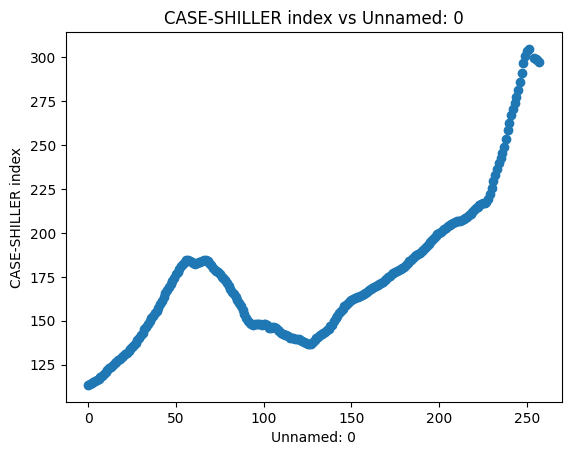

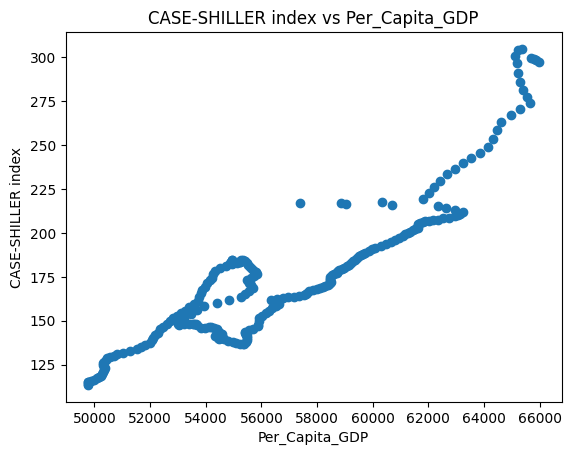

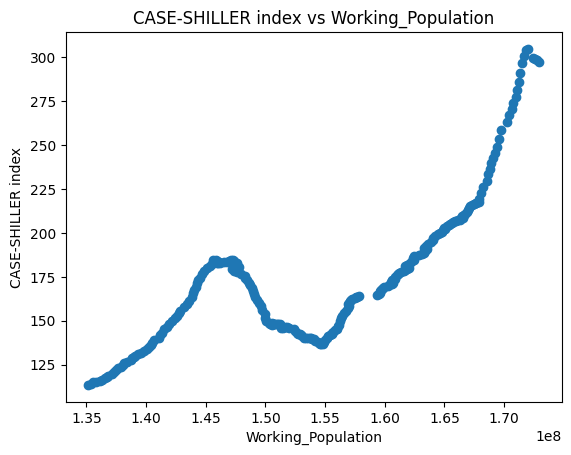

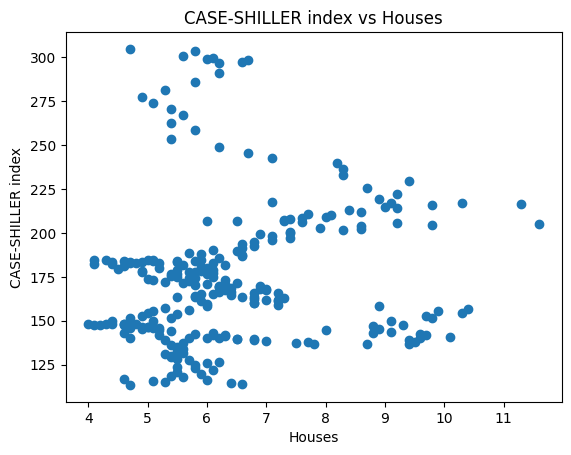

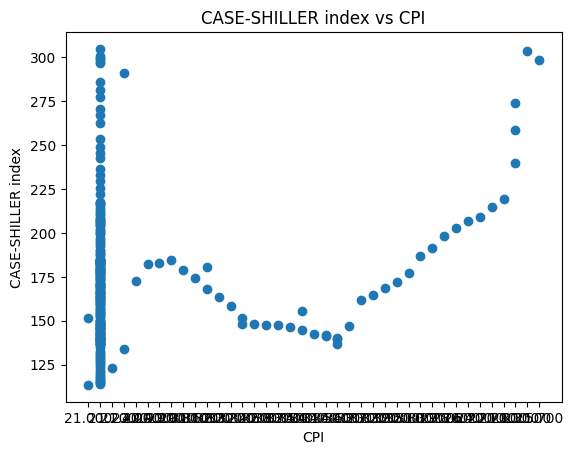

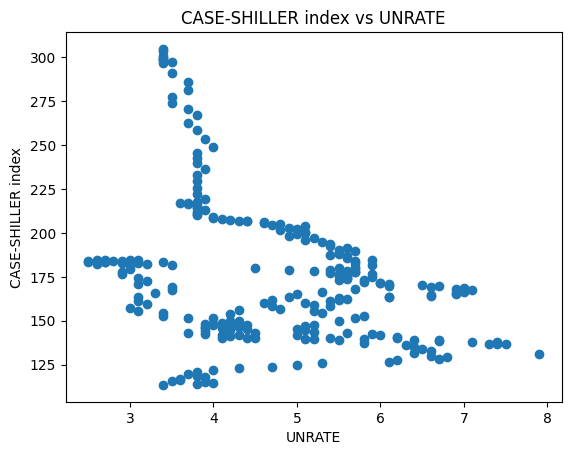

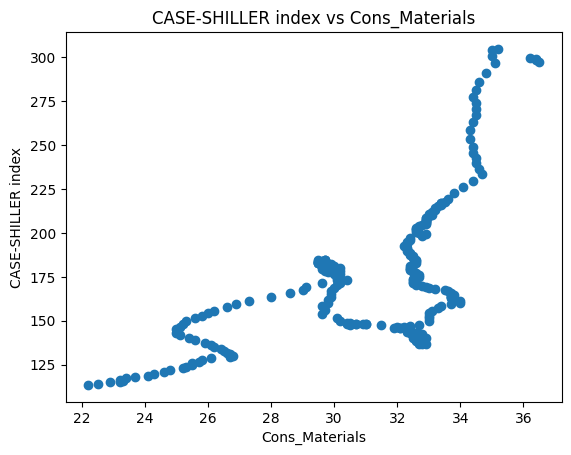

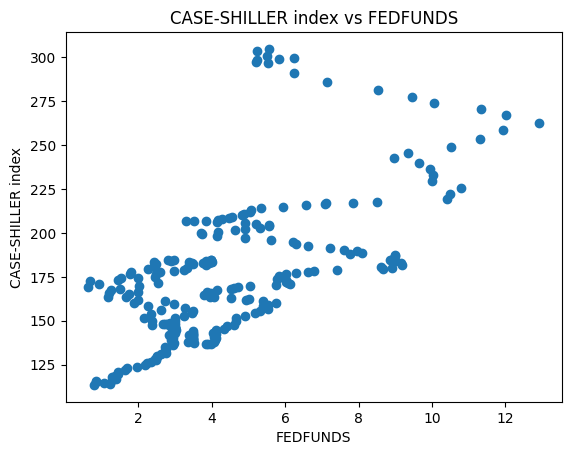

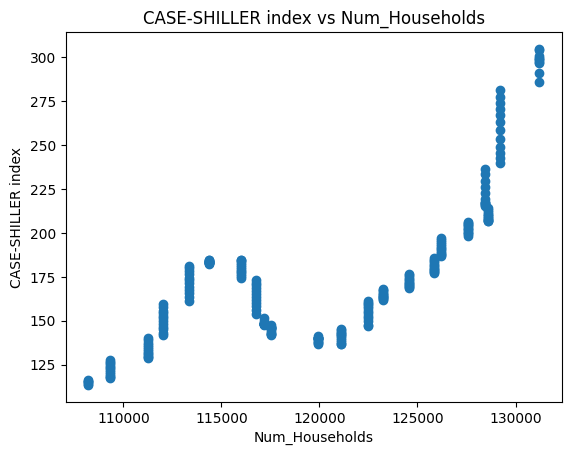

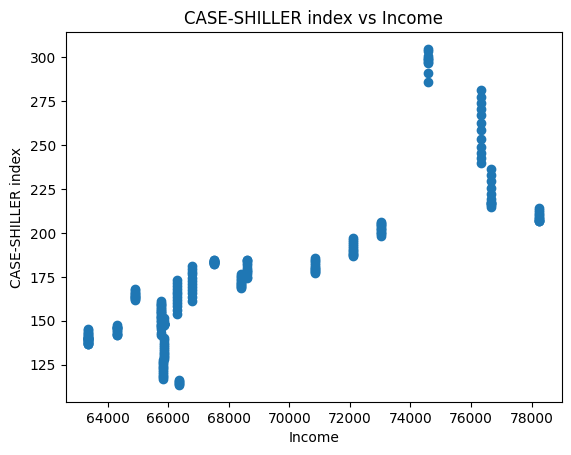

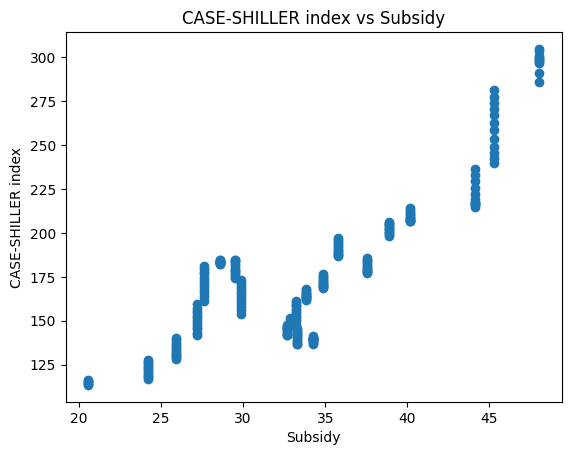

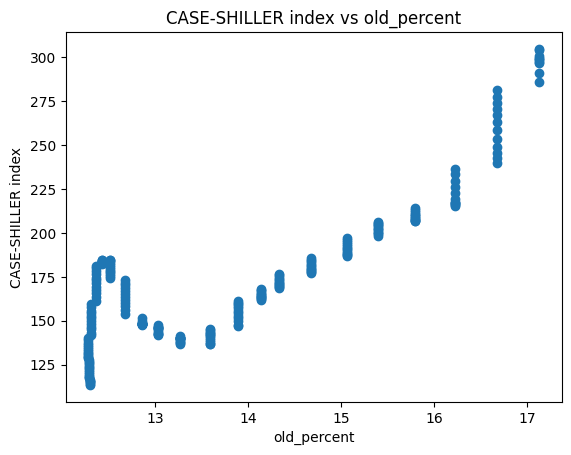

In [34]:
# Plotting scatter plots of the CASE-SHILLER index vs features

for feature in X.columns:
    plt.figure()
    plt.scatter(x = X[feature], y = y)
    plt.xlabel(feature)
    plt.ylabel("CASE-SHILLER index")
    plt.title(f"CASE-SHILLER index vs {feature}")

From the correlation matrix and the scatter plots, the following conclusions can be made-

- Unemployment rate is negatively correlated with the home prices. Which makes sense.
- Number of new houses has almost 0 correlation. This is unexpected as one would think that the number of houses supplied should also affect home prices. Maybe the number of new houses built are not enough to bring the prices down significantly.
- Impact of the great recession is reflected in almost all the plots.
- Interest rates have a slight negative impact on the home prices.
- All the other variables are positively correlated with the home prices.

From the correlation matrix above, it can be seen that several pairs of independent variables have high correlation. Let's drop one column from each such pair as they will cause multicollinearity. We will drop the column which has lower correlation with the target.

In [35]:
# Dropping multicollinearity columns
mult_cols = ["Working_Population", "CPI", "Num_Households",
             "Subsidy", "old_percent", "Cons_Materials", "Income"]
df.drop(columns = mult_cols, inplace = True)
X = df

### Model Building

In [36]:
# Scaling
scalar = MinMaxScaler()
X = scalar.fit_transform(X)

In [37]:
# Splitting data into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size= 0.2, random_state= 42)

In [38]:
# Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_valid)
score = r2_score(pred, y_valid)
print("The r2_score for the validation set is: ", score)

The r2_score for the validation set is:  0.9358545009980883


The r2 score is close to 1. It means that the model predicts the target variable with good accuracy.

In [39]:
#Printing the regression coefficients of different variables
coefs = model.coef_
cols = df.columns
for i in range(len(coefs)):
    print(f"The coefficient for {cols[i]} is {coefs[i]}")

The coefficient for Unnamed: 0 is -57.45060643944006
The coefficient for Per_Capita_GDP is 206.73860317119926
The coefficient for Houses is -15.318397206494062
The coefficient for UNRATE is -37.06626936284269
The coefficient for FEDFUNDS is 5.045424101310019


In [40]:
# The intercept
print("The intercept is: ", model.intercept_)


The intercept is:  132.76842430625584


A few variables that could have been studied are below.

- Net-immigration (It is supposed to have a positive impact. No suitable data could be found)
- Marriage Rate (People tend to buy homes after they get married. So, it might have some effect. No data could be found)
- Average house size (The data was available only for the years after 2015. Though it is expected that an increase in the average house size would increase prices, it is found that the average home size has been consistently decreasing although the prica has been increasing)
- Land availability (Less land, higher prices. Perhaps this is why the prices has been rising even though the average house size has been decreasing. No relevant data could be found)
- Tax Rate (Too many brackets (7) and could not analyse due to time)
- Number of active listings (Data prior to 2017 was not found)